# Task 1

### Read CoNLL Data

In [1]:
def loadConnl(filePath:str, maxSentLen:int=32):
    # read all lines of the file
    raw = open(filePath, 'r').readlines()
    all_x = []
    point = []
    # split each line into its components and ...
    for line in raw:
        stripped_line = line.strip().split(' ')  #
        point.append(stripped_line)
        # ... group lines that form a sentence into a new list
        if line == '\n':
            all_x.append(point[:-1])
            point = []
    # ignore -DOCSTART-
    all_xx = []
    for x in all_x:
        if x[0][0] != '-DOCSTART-':
            all_xx.append(x)
    #all_x = all_xx[:-1]
    all_xx = all_xx
    print("total number of sentences", len(all_xx))
    lengths = [len(x) for x in all_xx]
    # sort out sentences that are too long
    print('max sentence length', max(lengths))
    short_x = [x for x in all_xx if len(x) < maxSentLen]
    if max(lengths) > maxSentLen:
        print("keep only", len(short_x), "sentences up to length", maxSentLen)

    print(short_x[:3])
    cols = []
    # collect all components in their own list
    # only interested in columns with index 0 (tokens) and 3 (ner_tags)
    for icol in range(4):
        col = [[c[icol] for c in x] for x in short_x]
        cols.append(col)
    
    return cols

In [2]:
def change_nes(cols):
    for isent in range(len(cols[3])): # loop over all sentences
        sent = cols[1][isent]
        for iw in range(len(sent)):
            word = sent[iw]
            if 'PER' in word:
                word = 'PER'
            if 'LOC' in word:
                word = 'LOC'
            if 'ORG' in word:
                word = 'ORG'
            if 'MISC' in word:
                word = 'MISC'
            sent[iw] = word
    return cols

In [3]:
def create_caps(cols):
    caps = []
    for sent in cols[0]:
        capsSent = []
        for wrd in sent:
            if wrd[0].isupper():
                capsSent.append('U')
            else:
                capsSent.append('L')
        caps.append(capsSent)
    return caps

In [4]:
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tfversion = tf.__version__.split('.')
#assert (int(tfversion[0]) >= 1
#        and int(tfversion[1]) >= 5)  # require tf version 1.5
assert (sys.version_info[0] == 3)  # need python 3
dataPath = '/content/'

maxSeqLen = 32
cols = loadConnl(dataPath + 'train.txt', maxSentLen=maxSeqLen)
cols = change_nes(cols)

caps = []
for sent in cols[0]:
    capsSent = []
    for wrd in sent:
        if wrd[0].isupper():
            capsSent.append('U')
        else:
            capsSent.append('L')
    caps.append(capsSent)
cols.append(create_caps(cols))

total number of sentences 14041
max sentence length 113
keep only 12464 sentences up to length 32
[[['EU', 'NNP', 'B-NP', 'B-ORG'], ['rejects', 'VBZ', 'B-VP', 'O'], ['German', 'JJ', 'B-NP', 'B-MISC'], ['call', 'NN', 'I-NP', 'O'], ['to', 'TO', 'B-VP', 'O'], ['boycott', 'VB', 'I-VP', 'O'], ['British', 'JJ', 'B-NP', 'B-MISC'], ['lamb', 'NN', 'I-NP', 'O'], ['.', '.', 'O', 'O']], [['Peter', 'NNP', 'B-NP', 'B-PER'], ['Blackburn', 'NNP', 'I-NP', 'I-PER']], [['BRUSSELS', 'NNP', 'B-NP', 'B-LOC'], ['1996-08-22', 'CD', 'I-NP', 'O']]]


In [5]:
import collections


def build_vocab(wordlist,
                prefixWords=['<END>', '<UNK>'],
                nmax_words=10000,
                min_count=-1):
    counter = collections.Counter(wordlist)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    print("total vocab size", len(count_pairs))
    print("word count=", count_pairs[:8])
    print("count-histo", count_histo(count_pairs, countMax=10))
    if nmax_words < len(count_pairs):
        count_pairs = count_pairs[:nmax_words]
        print("minimal count included:", count_pairs[nmax_words - 1])
        nmax = -1
    words, _ = list(zip(*count_pairs))
    words = prefixWords + list(words)
    word_to_id = dict(zip(words, range(len(words))))
    print("vocab size", len(words))
    return word_to_id, inverse_vocab(word_to_id), count_pairs


def count_histo(count_pairs, countMax=20):
    hist = []
    cnt = 1
    for iw in range(len(count_pairs) - 1, 0, -1):
        if count_pairs[iw][1] == cnt:
            info = (iw, count_pairs[iw][0], count_pairs[iw][1])
            hist.append(info)
            if cnt >= countMax: break
            else: cnt += 1

    return hist


def inverse_vocab(word_to_id):
    """ create inverse vocabulary id_to_word """
    id_to_word = dict()
    for key in word_to_id:
        id_to_word[word_to_id[key]] = key
    return id_to_word


def lookup_word(word, word_to_id, unk='<UNK>'):
    if word in word_to_id:
        return word_to_id[word]
    else:
        return word_to_id[unk]


def lookup_words(wordlist, word_to_id, unk='<UNK>'):
    """wordlist is a list of lists"""
    ires = []
    for sent in wordlist:
        isent = []
        for word in sent:
            isent.append(lookup_word(word, word_to_id, unk=unk))
        ires.append(isent)
    return ires

In [6]:
# create vocabularies and transform to integers
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
to_categorical = tf.keras.utils.to_categorical
featNames = ['word', 'pos', 'phrase', 'ne', 'caps']

to_id = dict()
id_to = dict()
intToks = dict()
padded = dict()
onehot = dict()
preWords = [['<END>', '<UNK>'], ['<END>'], ['<END>'], ['<END>'], ['<END>']]

for ifeat in range(len(featNames)):
    feat = featNames[ifeat]
    print("====", feat, "====")
    wordlist = [c for x in cols[ifeat] for c in x]
    #--- build vocabulary
    to_id[feat], id_to[feat], _ = build_vocab(
        wordlist, prefixWords=preWords[ifeat], nmax_words=11972, min_count=2)
    #--- lookup in codes for words
    intToks[feat] = lookup_words(cols[ifeat], to_id[feat], unk='<UNK>')
    print('toks[', feat, ']', cols[ifeat][:2])
    print('intToks[', feat, ']', intToks[feat][:2])

    padded[feat] = pad_sequences(
        intToks[feat],
        maxlen=maxSeqLen,
        padding='post',
        truncating='post',
        value=0.0)
    print('padded[', feat, ']', padded[feat][:2])
    # one-hot encoding
    if feat == 'ne':
        onehot[feat] = to_categorical(padded[feat])
        print('onehot[', feat, ']', onehot[feat][:2])

==== word ====
total vocab size 20117
word count= [('.', 5811), (',', 4509), ('the', 4122), ('(', 2549), (')', 2548), ('of', 2200), ('in', 2065), ('to', 2026)]
count-histo [(20116, 'zvezda', 1), (9706, 'zinc', 2), (6360, 'yesterday', 3), (4697, 'yuan', 4), (3697, 'weapon', 5), (3076, 'wounds', 6), (2621, 'written', 7), (2265, 'wrote', 8), (2013, 'within', 9), (1778, 'young', 10)]
minimal count included: ('864148', 1)
vocab size 11974
toks[ word ] [['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn']]
intToks[ word ] [[1114, 1, 240, 930, 9, 4338, 226, 9038, 2], [539, 1622]]
padded[ word ] [[1114    1  240  930    9 4338  226 9038    2    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 539 1622    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
==== pos ====
total vo

## Process Test data

In [7]:
cols_val = loadConnl(dataPath + 'test.txt', maxSentLen=maxSeqLen)
cols_val = change_nes(cols_val)
cols_val.append(create_caps(cols_val))
intToks_val = dict()
padded_val = dict()
onehot_val = dict()

for ifeat in range(len(featNames)):
    feat = featNames[ifeat]
    print("====", feat, "====")
    wordlist = [c for x in cols_val[ifeat] for c in x]
    intToks_val[feat] = lookup_words(cols_val[ifeat], to_id[feat], unk='<UNK>')
    print('toks_val[', feat, ']', cols_val[ifeat][:2])
    print('intToks_val[', feat, ']', intToks_val[feat][:2])

    padded_val[feat] = pad_sequences(
        intToks_val[feat],
        maxlen=maxSeqLen,
        padding='post',
        truncating='post',
        value=0.0)
    print('padded_val[', feat, ']', padded_val[feat][:2])
    # one-hot encoding
    if feat == 'ne':
        onehot_val[feat] = to_categorical(padded_val[feat])
        print('onehot_val[', feat, ']', onehot_val[feat][:2])

total number of sentences 3453
max sentence length 124
keep only 3125 sentences up to length 32
[[['SOCCER', 'NN', 'B-NP', 'O'], ['-', ':', 'O', 'O'], ['JAPAN', 'NNP', 'B-NP', 'B-LOC'], ['GET', 'VB', 'B-VP', 'O'], ['LUCKY', 'NNP', 'B-NP', 'O'], ['WIN', 'NNP', 'I-NP', 'O'], [',', ',', 'O', 'O'], ['CHINA', 'NNP', 'B-NP', 'B-PER'], ['IN', 'IN', 'B-PP', 'O'], ['SURPRISE', 'DT', 'B-NP', 'O'], ['DEFEAT', 'NN', 'I-NP', 'O'], ['.', '.', 'O', 'O']], [['Nadim', 'NNP', 'B-NP', 'B-PER'], ['Ladki', 'NNP', 'I-NP', 'I-PER']], [['AL-AIN', 'NNP', 'B-NP', 'B-LOC'], [',', ',', 'O', 'O'], ['United', 'NNP', 'B-NP', 'B-LOC'], ['Arab', 'NNP', 'I-NP', 'I-LOC'], ['Emirates', 'NNPS', 'I-NP', 'I-LOC'], ['1996-12-06', 'CD', 'I-NP', 'O']]]
==== word ====
toks_val[ word ] [['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.'], ['Nadim', 'Ladki']]
intToks_val[ word ] [[91, 16, 1, 1, 1, 984, 3, 1, 318, 1, 1, 2], [1, 1]]
padded_val[ word ] [[ 91  16   1   1   1 984   3   1 318 

## Create Batches

In [8]:
import math
batch_size = 32
num_batches = math.ceil(len(padded['word']) / batch_size)

# increase length of data with 0 sequences
inp_trn = {}
for idd in ['word','pos','phrase','caps']:
    inp_trn[idd] = np.zeros([num_batches * batch_size, maxSeqLen])
    for iseq in range(len(padded[idd])):
        inp_trn[idd][iseq] = padded[idd][iseq]
    print("inp_trn[",idd,"].shape", inp_trn[idd].shape)

inp_nes = np.zeros([num_batches * batch_size, maxSeqLen, len(to_id['ne'])])
for iseq in range(len(onehot['ne'])):
    inp_nes[iseq] = onehot['ne'][iseq]  # on-hot encoded
print("inp_nes.shape", inp_nes.shape)

# increase length of data with 0 sequences
num_batches_val= math.ceil(len(padded_val['word']) / batch_size)

inp_val = {}
for idd in ['word','pos','phrase','caps']:
    inp_val[idd] = np.zeros([num_batches_val * batch_size, maxSeqLen])
    for iseq in range(len(padded_val[idd])):
        inp_val[idd][iseq] = padded_val[idd][iseq]
    print("inp_val[",idd,"].shape", inp_val[idd].shape)

inp_nes_val = np.zeros([num_batches_val * batch_size, maxSeqLen, len(to_id['ne'])])
for iseq in range(len(onehot_val['ne'])):
    inp_nes_val[iseq] = onehot_val['ne'][iseq]  # on-hot encoded
print("inp_nes_val.shape", inp_nes_val.shape)

inp_trn[ word ].shape (12480, 32)
inp_trn[ pos ].shape (12480, 32)
inp_trn[ phrase ].shape (12480, 32)
inp_trn[ caps ].shape (12480, 32)
inp_nes.shape (12480, 32, 10)
inp_val[ word ].shape (3136, 32)
inp_val[ pos ].shape (3136, 32)
inp_val[ phrase ].shape (3136, 32)
inp_val[ caps ].shape (3136, 32)
inp_nes_val.shape (3136, 32, 10)


# Task 2

## Read GLOVE embedding

In [9]:
import numpy as np
import codecs


def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {}  # word to its corresponding coefficients
    word2index = {}  # word to word-index
    with codecs.open(fp,encoding="utf8") as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim + 1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs) + 1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0] == embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix


    return word2index, np.asarray(embedding_matrix)

In [10]:
glove_emb_size = 200
fp = '/content/glove.6B.200d.txt'
print("reading file " + fp)
glove_word2index, glove_emb_full = load_glove_embeddings(
    fp, glove_emb_size, include_empty_char=True)
print('glove_emb_full.shape', glove_emb_full.shape, 'len(glove_word2index)',
      len(glove_word2index))

reading file /content/glove.6B.200d.txt
glove_emb_full.shape (325950, 200) len(glove_word2index) 325950


In [11]:
# select GLOVE embeddings in vocabulary
idx2word=id_to['word']
glove_embeddings = np.zeros((len(idx2word), glove_emb_size))
notFound =0
for idx in range(len(idx2word)):
    word = idx2word[idx].lower()
    if word in glove_word2index:
        glove_idx = glove_word2index[word]
        glove_embeddings[idx, :] = glove_emb_full[glove_idx]
    else: 
        notFound +=1
        glove_embeddings[idx, :] = np.random.uniform(size=glove_emb_size,low=0.5,high=0.5)
print('glove_embeddings.shape',glove_embeddings.shape)
print("words notFound",notFound)

glove_embeddings.shape (11974, 200)
words notFound 1524


# Task 3

## Multilayer Bidirectional LSTM

In [12]:
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Input,Add,MaxPool2D,Flatten,AveragePooling2D,Dense,BatchNormalization,ZeroPadding2D,Activation,Concatenate,UpSampling2D
from tensorflow.keras.models import Model

In [13]:
Input = tf.keras.Input
LSTM = tf.keras.layers.LSTM
Embedding = tf.keras.layers.Embedding
concatenate = tf.keras.layers.concatenate
TimeDistributed = tf.keras.layers.TimeDistributed
Bidirectional = tf.keras.layers.Bidirectional
Dense = tf.keras.layers.Dense
K = tf.keras.backend

emb_size = 70
emb_size_pos = 6
emb_size_phrase = 5
emb_size_caps = 1
hid_size = 100
numLay = 3
drop_prb = 0.10
useGlove = True
trainGlove = False
if useGlove: emb_size = glove_emb_size

words = Input(batch_shape=(batch_size, maxSeqLen), name='words')
pos = Input(batch_shape=(batch_size, maxSeqLen), name='pos')
phrase = Input(batch_shape=(batch_size, maxSeqLen), name='phrase')
caps = Input(batch_shape=(batch_size, maxSeqLen), name='caps')

if useGlove:
    word_emb = tf.keras.layers.Embedding(
        len(to_id['word']),
        emb_size,
        name="word_emb",
        mask_zero=True,
        weights=[glove_embeddings],  # set the embedding matrix to glove
        trainable=trainGlove)(words)
else:
    word_emb = tf.keras.layers.Embedding(
        len(to_id['word']), emb_size, mask_zero=True, name="word_emb")(words)

pos_emb = tf.keras.layers.Embedding(
    len(to_id['pos']), emb_size_pos, mask_zero=True, name="pos_emb")(pos)
phrase_emb = tf.keras.layers.Embedding(
    len(to_id['phrase']), emb_size_phrase, mask_zero=True,
    name="phrase_emb")(phrase)
caps_emb = tf.keras.layers.Embedding(
    len(to_id['caps']), emb_size_caps, mask_zero=True, name="caps_emb")(caps)

embeddings = concatenate(
    [word_emb, pos_emb, phrase_emb, caps_emb], name='embeddings')

fw = {-1: embeddings}
bw = {-1: embeddings}
for ilay in range(numLay):  # create a number of layers
    fw[ilay] = LSTM(
        hid_size,
        return_sequences=True,
        dropout=drop_prb,
        input_shape=(maxSeqLen, emb_size),
        name='fw' + str(ilay))(fw[ilay - 1])
    bw[ilay] = LSTM(
        hid_size,
        return_sequences=True,
        go_backwards=True,
        dropout=drop_prb,
        input_shape=(maxSeqLen, emb_size),
        name='bw' + str(ilay))(bw[ilay - 1])
concat = concatenate([fw[numLay - 1], bw[numLay - 1]])

neProbs = TimeDistributed(Dense(len(to_id['ne']),
                                activation='softmax'))(concat)
model = tf.keras.Model(inputs=[words, pos, phrase, caps], outputs=neProbs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(32, 32)]           0           []                               
                                                                                                  
 pos (InputLayer)               [(32, 32)]           0           []                               
                                                                                                  
 phrase (InputLayer)            [(32, 32)]           0           []                               
                                                                                                  
 caps (InputLayer)              [(32, 32)]           0           []                               
                                                                                              

## Implement callback

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


class Metrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.conf_mats = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(
            self.model.predict(self.validation_data[0]))).round()
        val_pred_mx = np.argmax(val_predict,axis=2).flatten()
        val_targ = self.validation_data[1]
        val_targ_mx = np.argmax(val_targ,axis=2).flatten()
        ncat = val_targ.shape[2]
        cm = conf_mat(val_targ_mx, val_pred_mx,
                      class_names=id_to['ne'], ncat=len(id_to['ne']))
        cm.print_metrics()
        self.conf_mats.append(cm)
        
metrics = Metrics()
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

In [15]:
# confusion matrix
class conf_mat(object):
    def __init__(self,
                 iclass_true,
                 iclass_pred,
                 class_names=None,
                 ncat=-1,
                 excude0=True):
        self.cm = np.zeros([ncat, ncat])
        assert len(iclass_true) == len(iclass_pred)
        for iobs in range(len(iclass_true)):
            if iclass_true[iobs] != 0:
                self.cm[iclass_true[iobs], iclass_pred[iobs]] += 1
        if class_names is None:
            self.class_names = ["class" + str(ic) for ic in range(ncat)]
        else:
            assert len(class_names) == ncat
            self.class_names = class_names
        self.ncat = ncat
        self.nsupport = np.zeros([ncat])
        self.nassigned = np.zeros([ncat])
        self.prec = np.zeros([ncat])
        self.recall = np.zeros([ncat])
        self.f1 = np.zeros([ncat])

        for ic in range(self.ncat):
            self.nsupport[ic] = np.sum(self.cm[ic, :])
            self.nassigned[ic] = np.sum(self.cm[:, ic])
            if self.nassigned[ic] > 0:
                self.prec[ic] = (self.cm[ic, ic] * 1.0 / self.nassigned[ic])
            if self.nsupport[ic] > 0:
                self.recall[ic] = (self.cm[ic, ic] * 1.0 / self.nsupport[ic])
            if self.recall[ic] != 0 and self.prec[ic] != 0:
                self.f1[ic] = 2 / (1.0 / self.recall[ic] + 1.0 / self.prec[ic])

    def print_metrics(self):
        for ic in range(self.ncat):
            st = ''
            if self.nsupport[ic] > 0:
                st = self.class_names[ic] + "\t "
                st += "prec=\t" + '%3.1f' % (100.0 * self.prec[ic])
                st += " rec=\t" + '%3.1f' % (100.0 * self.recall[ic])
                st += " F=\t" + '%3.1f' % (100.0 * self.f1[ic])
                st += " supp=\t" + '%d' % (self.nsupport[ic])
            print(st)
            
    def get_metrics(self,metric='f1'):
        """ extract a metric from the confusion matrices """
        result = {}
        nn = len(self.conf_mats)
        class_names = self.conf_mats[0].class_names
        for ic in range(len(class_names)):
            result[class_names[ic]] = np.zeros([nn])
        
        for it in range(nn):
            cm = self.conf_mats[it]
            if metric=='f1': 
                v = cm.f1
            elif metric == 'prec':
                v = cm.prec
            elif metric == 'recall':
                v = cm.recall
            elif metric == 'support':
                v = cm.support
            for ic in range(cm.ncat):
                result[class_names[ic]][it] = v[ic]
        return result

## Training the Model and make Prediction  
## Display Confusion Matrix  

In [16]:
epochs = 2

SGD = tf.keras.optimizers.SGD
K = tf.keras.backend
sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

losses_trn = []
losses_val = []
best_loss = 1.0E30
n_larger = 0
n_larger_max = 3 # number o
print("Train for", epochs, "epochs ...")
for epoch in range(epochs):
    history = model.fit(
        [inp_trn['word'], inp_trn['pos'], inp_trn['phrase'], inp_trn['caps']],
        inp_nes,
        batch_size=batch_size,
        epochs=1,
        verbose=1)

    loss_val = model.evaluate(
        [inp_val['word'], inp_val['pos'], inp_val['phrase'], inp_val['caps']],
        inp_nes_val, verbose=0,
        batch_size=batch_size)
    losses_val.append(loss_val)
    loss_trn = history.history["loss"][0]
    losses_trn.append(loss_trn)
    print("epoch", epoch, "loss-train %8.4f" % loss_trn,
          "loss-val %8.4f" % loss_val)
    if loss_val > best_loss:
        n_larger += 1
    else:
        n_larger = 0
        best_loss = loss_val
    if n_larger > n_larger_max:
        # check if loss-val is larger than minimum of last losses
        break

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Train for 2 epochs ...
390/390 [==============================] - 54s 82ms/step - loss: 0.2907
epoch 0 loss-train   0.2907 loss-val   0.2490
390/390 [==============================] - 32s 82ms/step - loss: 0.2446
epoch 1 loss-train   0.2446 loss-val   0.1807


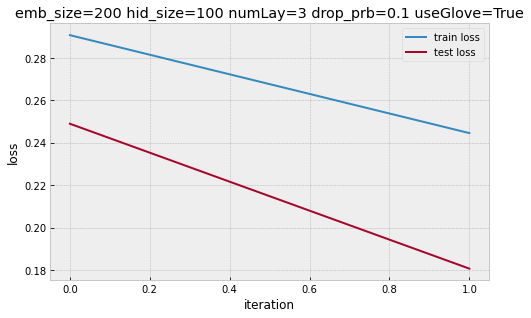

In [17]:
# plot history
import matplotlib as mpl
mpl.style.use('bmh') # bmh, seaborn, Solarize_Light2, ggplot, fast, classic, default
plt.figure(figsize=(20/2.54,12/2.54))

plt.plot(losses_trn, label='train loss')
plt.plot(losses_val, label='test loss')
plt.legend()
st = 'emb_size='+str(emb_size)+' hid_size='+str(hid_size)+' numLay='+str(numLay) 
st += ' drop_prb='+str(drop_prb)+' useGlove='+str(useGlove)
plt.title(st)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

In [18]:
val_predict = model.predict(
        [inp_val['word'], inp_val['pos'], inp_val['phrase'], inp_val['caps']],
        verbose=0,
        batch_size=batch_size)
val_pred_mx = np.argmax(val_predict,axis=2).flatten()
val_targ = inp_nes_val
val_targ_mx = np.argmax(val_targ,axis=2).flatten()
ncat = val_targ.shape[2]
cm = conf_mat(val_targ_mx, val_pred_mx,
                      class_names=id_to['ne'], ncat=len(id_to['ne']))

In [19]:
cm.print_metrics()
import pandas as pd
nam = [nm for nm in cm.class_names.values()][1:]
nam
df = pd.DataFrame(cm.cm[1:,1:], index=nam, columns=nam)
print("\nConfusion matrix: row=true, col=predicted\n",df)


O	 prec=	83.4 rec=	99.7 F=	90.9 supp=	27500
B-LOC	 prec=	13.8 rec=	2.2 F=	3.7 supp=	1347
B-ORG	 prec=	15.3 rec=	0.7 F=	1.3 supp=	1326
B-PER	 prec=	26.6 rec=	1.8 F=	3.4 supp=	1172
I-PER	 prec=	54.5 rec=	26.9 F=	36.0 supp=	789
I-ORG	 prec=	0.0 rec=	0.0 F=	0.0 supp=	572
B-MISC	 prec=	0.0 rec=	0.0 F=	0.0 supp=	514
I-MISC	 prec=	0.0 rec=	0.0 F=	0.0 supp=	169
I-LOC	 prec=	0.0 rec=	0.0 F=	0.0 supp=	209

Confusion matrix: row=true, col=predicted
               O  B-LOC  B-ORG  B-PER  I-PER  I-ORG  B-MISC  I-MISC  I-LOC
O       27422.0   27.0    2.0    4.0   45.0    0.0     0.0     0.0    0.0
B-LOC    1306.0   29.0    0.0    1.0   11.0    0.0     0.0     0.0    0.0
B-ORG    1303.0    3.0    9.0    1.0   10.0    0.0     0.0     0.0    0.0
B-PER     998.0   45.0   48.0   21.0   60.0    0.0     0.0     0.0    0.0
I-PER     518.0   38.0    0.0   21.0  212.0    0.0     0.0     0.0    0.0
I-ORG     485.0   20.0    0.0   28.0   39.0    0.0     0.0     0.0    0.0
B-MISC    512.0    2.0    0.0    0.0  

In [20]:
import pandas as pd
nam = [nm for nm in cm.class_names.values()][1:]
nam
df = pd.DataFrame(cm.cm[1:,1:], index=nam, columns=nam)
df

,O,B-LOC,B-ORG,B-PER,I-PER,I-ORG,B-MISC,I-MISC,I-LOC
O,27422.0,27.0,2.0,4.0,45.0,0.0,0.0,0.0,0.0
B-LOC,1306.0,29.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0
B-ORG,1303.0,3.0,9.0,1.0,10.0,0.0,0.0,0.0,0.0
B-PER,998.0,45.0,48.0,21.0,60.0,0.0,0.0,0.0,0.0
I-PER,518.0,38.0,0.0,21.0,212.0,0.0,0.0,0.0,0.0
I-ORG,485.0,20.0,0.0,28.0,39.0,0.0,0.0,0.0,0.0
B-MISC,512.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-MISC,163.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
I-LOC,154.0,41.0,0.0,3.0,11.0,0.0,0.0,0.0,0.0


# Task 4

## LSTM using different parameters

In [21]:
Input = tf.keras.Input
LSTM = tf.keras.layers.LSTM
Embedding = tf.keras.layers.Embedding
concatenate = tf.keras.layers.concatenate
TimeDistributed = tf.keras.layers.TimeDistributed
Bidirectional = tf.keras.layers.Bidirectional
Dense = tf.keras.layers.Dense
K = tf.keras.backend

emb_size = 80
emb_size_pos = 8
emb_size_phrase = 6
emb_size_caps = 1
hid_size = 120
numLay = 3
drop_prb = 0.10
useGlove = True
trainGlove = False
if useGlove: emb_size = glove_emb_size

words = Input(batch_shape=(batch_size, maxSeqLen), name='words')
pos = Input(batch_shape=(batch_size, maxSeqLen), name='pos')
phrase = Input(batch_shape=(batch_size, maxSeqLen), name='phrase')
caps = Input(batch_shape=(batch_size, maxSeqLen), name='caps')

if useGlove:
    word_emb = tf.keras.layers.Embedding(
        len(to_id['word']),
        emb_size,
        name="word_emb",
        mask_zero=True,
        weights=[glove_embeddings],  # set the embedding matrix to glove
        trainable=trainGlove)(words)
else:
    word_emb = tf.keras.layers.Embedding(
        len(to_id['word']), emb_size, mask_zero=True, name="word_emb")(words)

pos_emb = tf.keras.layers.Embedding(
    len(to_id['pos']), emb_size_pos, mask_zero=True, name="pos_emb")(pos)
phrase_emb = tf.keras.layers.Embedding(
    len(to_id['phrase']), emb_size_phrase, mask_zero=True,
    name="phrase_emb")(phrase)
caps_emb = tf.keras.layers.Embedding(
    len(to_id['caps']), emb_size_caps, mask_zero=True, name="caps_emb")(caps)

embeddings = concatenate(
    [word_emb, pos_emb, phrase_emb, caps_emb], name='embeddings')

fw = {-1: embeddings}
bw = {-1: embeddings}
for ilay in range(numLay):  # create a number of layers
    fw[ilay] = LSTM(
        hid_size,
        return_sequences=True,
        dropout=drop_prb,
        input_shape=(maxSeqLen, emb_size),
        name='fw' + str(ilay))(fw[ilay - 1])
    bw[ilay] = LSTM(
        hid_size,
        return_sequences=True,
        go_backwards=True,
        dropout=drop_prb,
        input_shape=(maxSeqLen, emb_size),
        name='bw' + str(ilay))(bw[ilay - 1])
concat = concatenate([fw[numLay - 1], bw[numLay - 1]])

neProbs = TimeDistributed(Dense(len(to_id['ne']),
                                activation='softmax'))(concat)
model1= tf.keras.Model(inputs=[words, pos, phrase, caps], outputs=neProbs)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(32, 32)]           0           []                               
                                                                                                  
 pos (InputLayer)               [(32, 32)]           0           []                               
                                                                                                  
 phrase (InputLayer)            [(32, 32)]           0           []                               
                                                                                                  
 caps (InputLayer)              [(32, 32)]           0           []                               
                                                                                            

In [22]:
epochs = 4

SGD = tf.keras.optimizers.SGD
K = tf.keras.backend
sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy', optimizer=sgd)

losses_trn = []
losses_val = []
best_loss = 1.0E30
n_larger = 0
n_larger_max = 3 # number o
print("Train for", epochs, "epochs ...")
for epoch in range(epochs):
    history = model1.fit(
        [inp_trn['word'], inp_trn['pos'], inp_trn['phrase'], inp_trn['caps']],
        inp_nes,
        batch_size=batch_size,
        epochs=1,
        verbose=1)

    loss_val = model1.evaluate(
        [inp_val['word'], inp_val['pos'], inp_val['phrase'], inp_val['caps']],
        inp_nes_val, verbose=0,
        batch_size=batch_size)
    losses_val.append(loss_val)
    loss_trn = history.history["loss"][0]
    losses_trn.append(loss_trn)
    print("epoch", epoch, "loss-train %8.4f" % loss_trn,
          "loss-val %8.4f" % loss_val)
    if loss_val > best_loss:
        n_larger += 1
    else:
        n_larger = 0
        best_loss = loss_val
    if n_larger > n_larger_max:
        # check if loss-val is larger than minimum of last losses
        break

Train for 4 epochs ...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


390/390 [==============================] - 54s 86ms/step - loss: 0.2886
epoch 0 loss-train   0.2886 loss-val   0.2460
390/390 [==============================] - 33s 86ms/step - loss: 0.2342
epoch 1 loss-train   0.2342 loss-val   0.1628
390/390 [==============================] - 34s 88ms/step - loss: 0.1454
epoch 2 loss-train   0.1454 loss-val   0.1189
390/390 [==============================] - 33s 86ms/step - loss: 0.1072
epoch 3 loss-train   0.1072 loss-val   0.0951


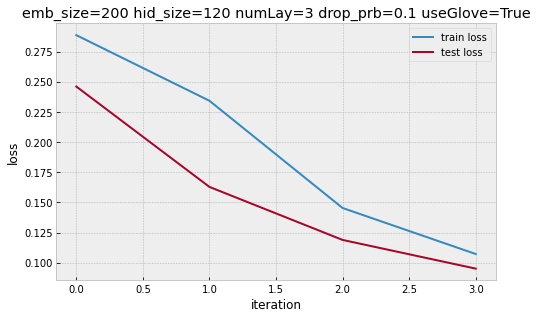

In [23]:
# plot history
import matplotlib as mpl
mpl.style.use('bmh') # bmh, seaborn, Solarize_Light2, ggplot, fast, classic, default
plt.figure(figsize=(20/2.54,12/2.54))

plt.plot(losses_trn, label='train loss')
plt.plot(losses_val, label='test loss')
plt.legend()
st = 'emb_size='+str(emb_size)+' hid_size='+str(hid_size)+' numLay='+str(numLay) 
st += ' drop_prb='+str(drop_prb)+' useGlove='+str(useGlove)
plt.title(st)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

In [24]:
val_predict = model1.predict(
        [inp_val['word'], inp_val['pos'], inp_val['phrase'], inp_val['caps']],
        verbose=0,
        batch_size=batch_size)
val_pred_mx = np.argmax(val_predict,axis=2).flatten()
val_targ = inp_nes_val
val_targ_mx = np.argmax(val_targ,axis=2).flatten()
ncat = val_targ.shape[2]
cm = conf_mat(val_targ_mx, val_pred_mx,
                      class_names=id_to['ne'], ncat=len(id_to['ne']))

In [25]:
cm.print_metrics()
import pandas as pd
nam = [nm for nm in cm.class_names.values()][1:]
nam
df = pd.DataFrame(cm.cm[1:,1:], index=nam, columns=nam)
print("\nConfusion matrix: row=true, col=predicted\n",df)


O	 prec=	97.3 rec=	98.4 F=	97.8 supp=	27500
B-LOC	 prec=	64.1 rec=	55.7 F=	59.6 supp=	1347
B-ORG	 prec=	48.6 rec=	43.4 F=	45.8 supp=	1326
B-PER	 prec=	62.7 rec=	73.9 F=	67.8 supp=	1172
I-PER	 prec=	74.8 rec=	93.5 F=	83.2 supp=	789
I-ORG	 prec=	48.1 rec=	60.8 F=	53.7 supp=	572
B-MISC	 prec=	38.8 rec=	23.0 F=	28.9 supp=	514
I-MISC	 prec=	81.8 rec=	21.3 F=	33.8 supp=	169
I-LOC	 prec=	0.0 rec=	0.0 F=	0.0 supp=	209

Confusion matrix: row=true, col=predicted
               O  B-LOC  B-ORG  B-PER  I-PER  I-ORG  B-MISC  I-MISC  I-LOC
O       27049.0   33.0   83.0   99.0  102.0  107.0    27.0     0.0    0.0
B-LOC      59.0  750.0  353.0  109.0    6.0    7.0    63.0     0.0    0.0
B-ORG     197.0  207.0  575.0  254.0    5.0   13.0    75.0     0.0    0.0
B-PER      80.0  123.0   56.0  866.0   28.0    7.0    12.0     0.0    0.0
I-PER      19.0    0.0    2.0    5.0  738.0   25.0     0.0     0.0    0.0
I-ORG      97.0   20.0   30.0    3.0   67.0  348.0     5.0     2.0    0.0
B-MISC    224.0   32.0 

In [26]:
import pandas as pd
nam = [nm for nm in cm.class_names.values()][1:]
nam
df = pd.DataFrame(cm.cm[1:,1:], index=nam, columns=nam)
df

,O,B-LOC,B-ORG,B-PER,I-PER,I-ORG,B-MISC,I-MISC,I-LOC
O,27049.0,33.0,83.0,99.0,102.0,107.0,27.0,0.0,0.0
B-LOC,59.0,750.0,353.0,109.0,6.0,7.0,63.0,0.0,0.0
B-ORG,197.0,207.0,575.0,254.0,5.0,13.0,75.0,0.0,0.0
B-PER,80.0,123.0,56.0,866.0,28.0,7.0,12.0,0.0,0.0
I-PER,19.0,0.0,2.0,5.0,738.0,25.0,0.0,0.0,0.0
I-ORG,97.0,20.0,30.0,3.0,67.0,348.0,5.0,2.0,0.0
B-MISC,224.0,32.0,82.0,44.0,6.0,8.0,118.0,0.0,0.0
I-MISC,66.0,1.0,1.0,0.0,9.0,52.0,4.0,36.0,0.0
I-LOC,15.0,4.0,1.0,2.0,25.0,156.0,0.0,6.0,0.0


# Task 5

# **Observation:**  



## First output  

emb_size = 70  
emb_size_pos = 6  
emb_size_phrase = 5  
hid_size = 100    

Total params: 2,969,194  
Trainable params: 574,394  
Non-trainable params: 2,394,800  


Epoch = 2  
epoch 0 ==> loss: 0.2907  
epoch 1 ==> loss: 0.2446    

## Second output  

emb_size = 80  
emb_size_pos = 8  
emb_size_phrase = 6  
hid_size = 120  

Total params: 3,182,987  
Trainable params: 788,187  
Non-trainable params: 2,394,800  

Epoch = 4  
epoch 0 ==> loss: 0.2886  
epoch 1 ==> loss: 0.2342  
epoch 2 ==> loss: 0.1454  
epoch 3 ==> loss: 0.1072    

# **Conclusion:**  

## As the values of emb_size, emb_size_pos, emb_size_phrase, hid_size increased there is a increase in the total parameters count and decrease in loss value.    

## Epoch value when incresed to 4 there is a decrease in the loss value.  